Vediamo se il pacchetto 'thermo' può essere utile. 

Installato tramite pip con i comandi:

> pip install thermo

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

final_db_processed = pd.read_csv('dataset/final_db_processed.csv')
use_db = final_db_processed.copy()
use_db.head(5)

,test_cas,species,conc1_type,exposure_type,obs_duration_mean,conc1_mean,atom_number,alone_atom_number,bonds_number,doubleBond,tripleBond,ring_number,Mol,MorganDensity,LogP,class,tax_order,family,genus
0,100-00-5,rerio,F,F,48.0,15.0,0.317908,2,0.488106,1,0,1.0,0.535725,1.300,2.2482,Actinopterygii,Cypriniformes,Cyprinidae,Danio
1,100-00-5,rerio,F,F,96.0,15.0,0.317908,2,0.488106,1,0,1.0,0.535725,1.300,2.2482,Actinopterygii,Cypriniformes,Cyprinidae,Danio
2,100-01-6,rerio,F,S,96.0,87.6,0.317908,2,0.488106,1,0,1.0,0.510371,1.300,1.1770,Actinopterygii,Cypriniformes,Cyprinidae,Danio
3,100-02-7,rerio,F,AQUA,48.0,26.5,0.317908,2,0.488106,1,0,1.0,0.511738,1.300,1.3004,Actinopterygii,Cypriniformes,Cyprinidae,Danio
4,100-44-7,rerio,F,S,96.0,4.0,0.217006,0,0.447258,0,0,1.0,0.493578,1.125,2.4254,Actinopterygii,Cypriniformes,Cyprinidae,Danio


In [58]:
cas_to_smiles = pd.read_csv('dataset/cas_to_smiles.csv').drop(columns = 'Unnamed: 0')
only_cas = pd.read_csv('dataset/only_cas.csv').drop(columns = 'Unnamed: 0')

# Verifica che i cas number tradotti da webchem siano uguali a quelli tradotti da thermo

In [38]:
from thermo.identifiers import smiles
from thermo.identifiers import CAS_from_any


smiles = smiles(only_cas.loc[0]['cas'])

print('SMILES prodotta da thermo: {}'.format(smiles))
print('CAS prodotto da thermo: {}'.format(CAS_from_any(smiles)))

print('SMILES prodotto da webchem R: {}'.format(cas_to_smiles.loc[0]['smiles']))
print('CAS prodotto da webchem R: {}'.format(cas_to_smiles.loc[1]['cas']))
print()
print('I due SMILES sono uguali? {}'.format(cas_to_smiles.loc[0]['smiles'] == smiles))

SMILES prodotta da thermo: [Cd+2].[Cl-].[Cl-]
CAS prodotto da thermo: 10108-64-2
SMILES prodotto da webchem R: [Cl-].[Cl-].[Cd++]
CAS prodotto da webchem R: 88-30-2

I due SMILES sono uguali? False


Vedendo il primo composto i due SMILES non coincidono. Considero opportuno mantenere i loro SMILES, ma lavorare con gli SMILES prodotti dalla libreria **thermo**.

In thermo c'è la funzione **MW** che passando il CAS Number produce il **peso molecolare**:

In [39]:
from thermo.identifiers import MW

cas_try = only_cas.loc[0]['cas']
mw_try = MW(cas_try)
print('Il peso molecolare di {} è {}'.format(cas_try, mw_try))

Il peso molecolare di 10108-64-2 è 183.318


In [5]:
only_cas = pd.read_csv('dataset/only_cas.csv', dtype = {'cas': str}).drop(columns = 'Unnamed: 0')

Come trovare gli smiles usando **thermo**

In [51]:
import pandas as pd
from thermo.identifiers import smiles


smile = pd.Series()

def find_smiles(cas):
    try:
        sm = smiles(cas)
    except:
        sm = 'NA'
    return sm

for i in only_cas['cas']:
    smile = smile.append(pd.Series(find_smiles(i)))

sum(smile == 'NA')

962

Ci sono dei problemi con il trovare lo smiles per tutti i composti. Sono 962 a fronte dei circa 400 composti di cui **thermo** non ha trovato la riproduzione in SMILES. Sarebbe possibile implementare almeno per quelli i pesi molecolari. Ho trovato su webchem la funzione che mi produce il peso molecolare.

Provo ad installare il pacchetto **ChemSpiPy**:

> pip install chemspipy

Non si può utilizzare perchè prevede una registrazione dell'azienda...

In [ ]:
only_cas[only_cas['cas']=='33878-50-1']

In [73]:
from thermo.chemical import Chemical

a = Chemical(only_cas.loc[0]['cas'])
# peso molecolare
print(a.MW)

183.318


# Giorno 2 -- ricerca water solubility FALLITA

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from thermo.chemical import Chemical

only_cas = pd.read_csv('dataset/only_cas.csv').drop(columns = 'Unnamed: 0')
cas_try = only_cas['cas'].loc[1]

a = Chemical(cas_try)
# octanol water partition --> KoW
print(a.solubility_parameter)

None


In [32]:
def water_sol(cas):
    try:
        out = Chemical(cas).solubility_parameter
    except:
        out  ='NA'
    return out

ws = pd.Series()
i=0
for cas in only_cas['cas']:
    i+=1
    ws  = ws.append(pd.Series(water_sol(cas)))
print(i)

3201


# Prova gruppi OH con rdkit

((10,), (24,), (28,), (34,))
yes
4


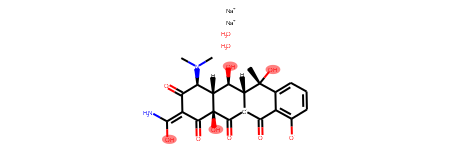

In [25]:
# Conteggio gruppi OH

from rdkit.Chem import MolFromSmarts
from rdkit.Chem import MolFromSmiles
import pandas as pd
cas_to_smiles = pd.read_csv('dataset/cas_to_smiles.csv')
sm = cas_to_smiles['smiles']

m = MolFromSmiles(sm.loc[25])
patt = MolFromSmarts('[OX2H]') #negli Smarts il gruppo OH si scrive in questo modo
# m.HasSubstructMatch(patt)

print(m.GetSubstructMatches(patt))

if m.GetSubstructMatches(patt):
    print('yes')
    print(len(m.GetSubstructMatches(patt)))
else:
    print('no')
    print(len(m.GetSubstructMatches(patt)))
m

# Conteggio gruppi OH tramite rdkit.Chem

In [21]:
from rdkit.Chem import MolFromSmarts
from rdkit.Chem import MolFromSmiles
import pandas as pd
import matplotlib.pyplot as plt

cas_to_smiles = pd.read_csv('dataset/cas_to_smiles.csv')
sm = cas_to_smiles['smiles']

def OH_count_fun(smile):
    try:
        m = MolFromSmiles(smile)
        patt = MolFromSmarts('[OX2H]')
        out = len(m.GetSubstructMatches(patt))
    except:
        out = 'NA'
    
    return out

In [22]:
oh_count = pd.Series()

for i in sm:
    oh_count = oh_count.append(pd.Series(OH_count_fun(i)))

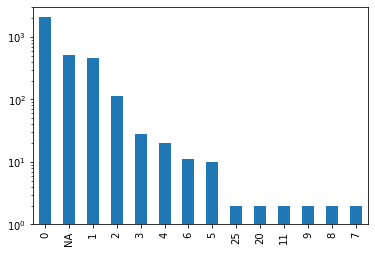

In [27]:
oh_count.value_counts().plot.bar(log = True)

Nella variabile **oh_count** ci sono i numeri di gruppi OH presenti nei composti.

# Conteggio gruppi OH brutale

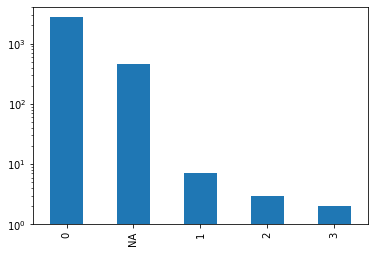

In [97]:
# Conteggio gruppi OH
cas_to_smiles = pd.read_csv('dataset/cas_to_smiles.csv')
sm = cas_to_smiles['smiles']
oh_count = list()
for i in sm:
    try:
        oh_count.append(i.count('OH'))
    except:
        oh_count.append('NA')

oh = pd.Series(oh_count)
oh.value_counts(dropna =False).plot.bar(log = True)

# Molecular Weight tramite rdkit.Chem.Descriptors

In [48]:
import pandas as pd
from rdkit.Chem.Descriptors import ExactMolWt
from rdkit.Chem import MolFromSmiles


cas_to_smiles = pd.read_csv('dataset/cas_to_smiles.csv')

def molWeight(smiles):
    try:
        out = ExactMolWt(MolFromSmiles(smiles))
    except:
        out = 'NA'
    return out

mw = pd.Series()
for i in cas_to_smiles['smiles']:
    mw = mw.append(pd.Series(molWeight(i)))

sum(mw == 'NA')

504